In [19]:
import numpy as np
import matplotlib.pyplot as plt
import obspy.signal as signal
from obspy import read
import os
from glob import glob
import pandas as pd
import fnmatch
import math
import torch
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
import torch.nn.functional as F
import pyproj
import matplotlib
import obspy.signal.filter
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta
import datetime
from numpy.matlib import repmat
from time import time
import scipy
import obspy
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.stats import norm



## Fig 14 Histogram - find reliable predictions


#### This step was actually done after predicting the sources, re-ran the seismic modeling to extract the synthetic picks, and comparing the synthetic vs field picks

In [4]:
xcorr_min = np.load('data/field/meq_predictions/2014/xcorr_min.npy')

## get the ones that are less than 150 ms
cri = np.where(xcorr_min<250)[0]
print(cri.shape)

(142,)


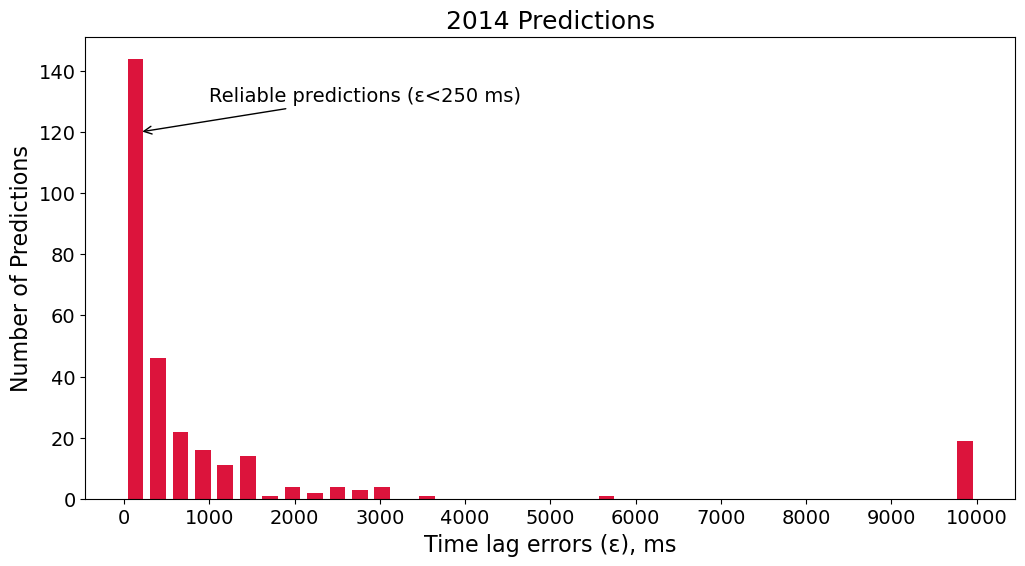

In [6]:
#All events XYZ
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
ax.hist(xcorr_min,bins="auto",rwidth=0.7,color='crimson')
ax.set_xticks(np.arange(0, 11000, 1000));
ax.set_xlabel('Time lag errors (ε), ms',fontsize=16)
ax.set_ylabel('Number of Predictions',fontsize=16)
ax.set_title('2014 Predictions',fontsize=18)
ax.annotate('Reliable predictions (ε<250 ms)',xy=(180,120),xytext=(1000,130), arrowprops = dict(arrowstyle='->',facecolor ='black'),fontsize=14,color='black');
# plt.savefig('Figures/14-timelag_losses_2014.jpg',bbox_inches='tight',dpi=300)



## Figure 15 - Field Predictions

In [7]:
## Load PMLP model
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3_mean = nn.Linear(200, 2)
        self.fc3_mean_depth = nn.Linear(200,1)
        self.fc3_log_std = nn.Linear(200, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean_rest = self.fc3_mean(x)
        mean_depth = torch.relu(self.fc3_mean_depth(x))
        log_std = self.fc3_log_std(x)
        mean = torch.cat((mean_rest,mean_depth),axis=-1)

        return mean, log_std

## Prediction function
def predict(model, X, num_samples=1):
        with torch.no_grad():
            mean, log_std = model(X)
            std = torch.exp(log_std)
            
            # Sample from Gaussian distribution
            samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
            
            # Return the average of samples
            return torch.mean(samples, dim=0)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device); print(torch.cuda.get_device_name())

def to_np(arr):
    return arr.detach().cpu().numpy()



cuda:0
NVIDIA GeForce RTX 4080


In [95]:
#### Load files
Best_Field_Picks = np.load('data/field/meq_waveforms/2014_Processed_Selected/Best_Field_Picks.npy')

#Compute cross correlations and apply deep learning
all_field_1stArr_waveform = []
all_field_xcorr_waveform = []
all_field_prediction_loc = []
all_field_loc_ones = []
all_field_timelag = []
dt = 0.004

np.random.seed(123)
torch.manual_seed(123)

## Load weights here because to ensure reproducibility
PMLP_model = MyModel(8,3).to(device).double()
PMLP_model.load_state_dict(torch.load('weights_logs/GoodRun_Combined_LV.pth')) 



for event_i in tqdm(range(len(Best_Field_Picks))):

    #get matching first arrival convert into waveform
    event_arr_trigger = Best_Field_Picks[event_i]
    #make delta
    delta_arr = np.zeros((8,4000))
    for i in range(8):
        get_trig_idx = event_arr_trigger[i]
        delta_arr[i,get_trig_idx]=1
    all_field_1stArr_waveform.append(delta_arr)

    #compute cross correlation
    sample_field_xcorr = []
    master_tr = delta_arr[2].copy()
    for i in range(8):
        dat = np.correlate(master_tr,delta_arr[i],'same')
        sample_field_xcorr.append(dat)
    sample_field_xcorr_np = np.array(sample_field_xcorr)
    #crop sides so that length is from 10000 to 1024
    all_field_xcorr_waveform.append(sample_field_xcorr_np)

    #extract where ones
    loc_one = []
    for i in range(8):
        sample = sample_field_xcorr_np[i]
        loc = np.where(sample==1)[0][0]
        loc_one.append(loc)
    loc_one = np.array(loc_one)
    all_field_loc_ones.append(loc_one)

    #convert location of ones to time lag in terms of *dt
    timelag_arr = loc_one-2000
    timelag_arr = timelag_arr*dt
    all_field_timelag.append(timelag_arr)
    # #convert to torch
    sample_field_time_lag= torch.tensor(timelag_arr)[None,:].to(device).double()
    
    #Prediction
    with torch.no_grad():
        PMLP_model.eval()
        ypred_test = predict(PMLP_model,sample_field_time_lag,num_samples=2000)
        ypred_test_np = np.squeeze(to_np(ypred_test))
        #put in array
        all_field_prediction_loc.append(ypred_test_np)


all_field_1stArr_waveform = np.array(all_field_1stArr_waveform)
all_field_xcorr_waveform = np.array(all_field_xcorr_waveform)
all_field_prediction_loc = np.squeeze(np.array(all_field_prediction_loc))
all_field_timelag = np.squeeze(np.array(all_field_timelag))


  0%|          | 0/292 [00:00<?, ?it/s]

100%|██████████| 292/292 [00:02<00:00, 97.95it/s] 


In [96]:
## Compute the one less than critieria, cri was computed after rerunning seismic modeling based on all_field_prediction_loc, compute the forward modeled picks, and compute the loss between synthetic vs field picks.
cri_best_field_picks = Best_Field_Picks[cri]
cri_prediction_loc = all_field_prediction_loc[cri]
cri_timelag = all_field_timelag[cri]

Best_PredFwd_FAs = np.load('data/field/meq_predictions/2014/Best_PredFwd_FAs.npy')
cri_best_predfwd_FAs = Best_PredFwd_FAs[cri]

# there are some bad predictions - See below for supporting info, likely due to bad data picks (high level of noise) and/or limitation of velocity model
cri2 = cri_prediction_loc[:,2]>1.8 # there are bad predictiosn above 1.8km
cri_prediction_loc = cri_prediction_loc[cri2]
cri_best_field_picks = cri_best_field_picks[cri2]
cri_best_predfwd_FAs = cri_best_predfwd_FAs[cri2]
cri_timelag = cri_timelag[cri2]


print(cri_best_field_picks.shape)
print(cri_prediction_loc.shape)
print(cri_best_predfwd_FAs.shape)


(128, 8)
(128, 3)
(128, 8)


In [97]:
#calculate events
print(len(np.where((cri_prediction_loc[:,2]<=2.057))[0])) #A
print(len(np.where((cri_prediction_loc[:,2]>=2.057)  & (cri_prediction_loc[:,2]<=2.439))[0])) #B
print(len(np.where((cri_prediction_loc[:,2]>=2.439)  & (cri_prediction_loc[:,2]<=2.634))[0])) #C
print(len(np.where((cri_prediction_loc[:,2]>=2.634)  & (cri_prediction_loc[:,2]<=2.908))[0])) #D
print(len(np.where((cri_prediction_loc[:,2]>2.908))[0])) #LAST
print(len(np.where((cri_prediction_loc[:,2]>3.05))[0])) #LAST

17
67
22
16
6
3


In [98]:
### Get uncertainties

def predict_uncertainties(model, X, num_samples=1):
    with torch.no_grad():
        mean, log_std = model(X)
        std = torch.exp(log_std)
        
        # Sample from Gaussian distribution
        samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
        
        return samples

# #Compute cross correlations and apply deep learning
cri_prediction_samples = []

dt = 0.004

np.random.seed(123)
torch.manual_seed(123)
for cri_event_i in tqdm(range(len(cri_prediction_loc))):

    each_cri_timelag = cri_timelag[cri_event_i]

    # #convert to torch
    sample_field_time_lag= torch.tensor(each_cri_timelag)[None,:].to(device).double()

    # ### apply probabilistic MLP
    InverseMagic = MyModel(8,3).to(device).double()
    InverseMagic.load_state_dict(torch.load('D:/PSU_Research/egg0/Geothermal/NNLoc/Synthetic_Case/weights_logs/DL_Combined/GoodRun_Combined_LV.pth')) 

    with torch.no_grad():
        InverseMagic.eval()
        ypred_test = predict_uncertainties(InverseMagic,sample_field_time_lag,num_samples=2000)
        ypred_test_np = np.squeeze(to_np(ypred_test))
        #put in array
        cri_prediction_samples.append(ypred_test_np)

cri_prediction_samples = np.array(cri_prediction_samples)
print(cri_prediction_samples.shape)


100%|██████████| 128/128 [00:00<00:00, 227.49it/s]

(128, 2000, 3)


In [99]:
### Compute Confidence Interval 

#compute lower and upper bounds for plotting
CI = 0.95

CI_bounds_uncert = []
for i in range(cri_prediction_samples.shape[0]):

    e_samples = cri_prediction_samples[i,:,0]
    n_samples = cri_prediction_samples[i,:,1]
    z_samples = cri_prediction_samples[i,:,2]

    CI_E = norm(*norm.fit(e_samples)).interval(CI)
    CI_N = norm(*norm.fit(n_samples)).interval(CI)
    CI_Z = norm(*norm.fit(z_samples)).interval(CI)
    CI_ENZ = np.stack((CI_E,CI_N,CI_Z),axis=1) #(2,3) - component, and lower and upper bound

    ea_pred_mean = cri_prediction_loc[i]

    ## loop through all components
    comp_bounds = np.zeros((2,3))
    for j in range(3):
        lower = abs(ea_pred_mean[j] - CI_ENZ[0,j])
        upper = abs(CI_ENZ[1,j] - ea_pred_mean[j])
        comp_bounds[0,j] = lower
        comp_bounds[1,j] = upper
    
    CI_bounds_uncert.append(comp_bounds)
CI_bounds_uncert = np.array(CI_bounds_uncert)
print(CI_bounds_uncert.shape)

CI_bounds_uncert_plot = CI_bounds_uncert.swapaxes(0,1)
print(CI_bounds_uncert_plot.shape)




(128, 2, 3)
(2, 128, 3)


(3,)


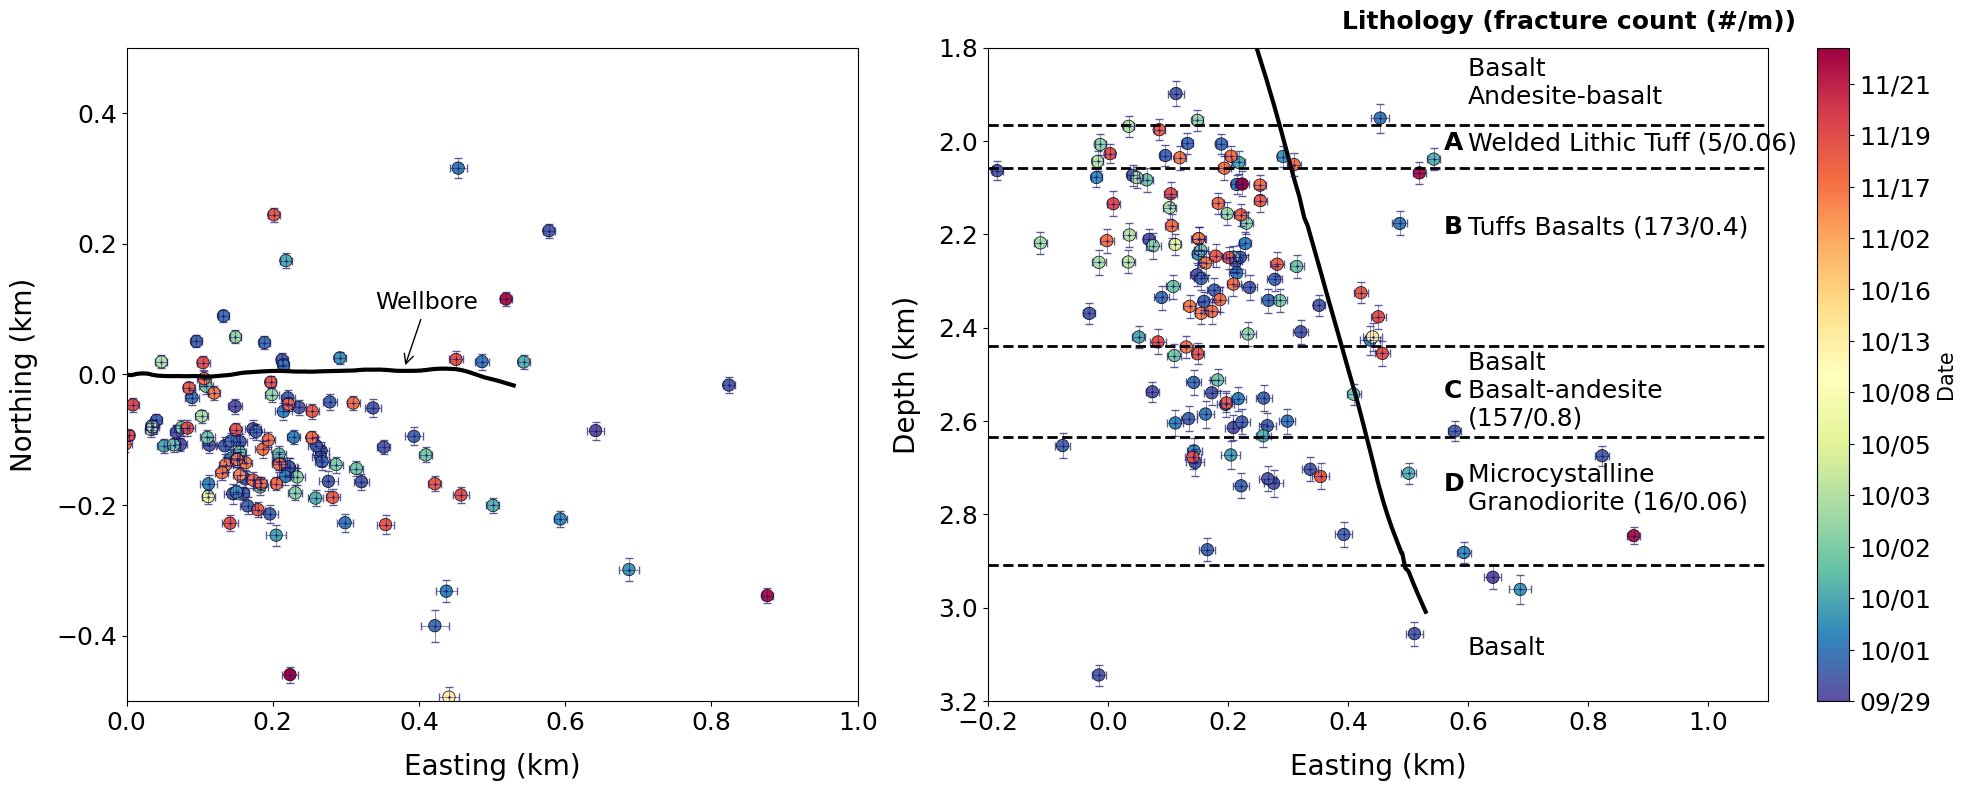

In [101]:
#### Combine both topview and cross section

# ## Get relevant event IDs
eventIDs = np.load('data/field/meq_waveforms/2014_Processed_Selected/waveforms_eventIDs.npy')
cri_eventIDs = eventIDs[cri]
cri_eventIDs = cri_eventIDs[cri2]
#wellbore
wb_coordinates = np.load('data/wellbore/wb_loc.npy')
wellhead = wb_coordinates[0]
wellhead_all = np.tile(wellhead,(96,1)); print(wellhead.shape)
wellhead_all[:,2] = 0
norm_wb_coordinates = wb_coordinates - wellhead_all

### Date labels
## convert to string
makestr = []
for i in range(len(cri_eventIDs)):
    ea = str(cri_eventIDs[i])
    ea_strp = ea[:6]
    makestr.append(ea_strp)
makestr = np.array(makestr)
# Convert strings to datetime
dates = [datetime.datetime.strptime(date, "%y%m%d") for date in makestr]
# Normalize between 0 and 1
dates_num = mdates.date2num(dates)
dates_norm = (dates_num - np.min(dates_num)) / (np.max(dates_num) - np.min(dates_num))

######### Top View ###############

#label ticks
matplotlib.rcParams['xtick.labelsize']=18
matplotlib.rcParams['ytick.labelsize']=18

# Create figure and plot
fig,axs = plt.subplots(1,2,figsize=(20,8),gridspec_kw={'width_ratios': [1.5, 2]})
ax = axs[0]
## range errors
# ax.errorbar(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,1]-wellhead[1]/1000,yerr=bounds_uncert_plot[:,:,0],xerr=abs(bounds_uncert_plot[:,:,1]),linewidth=0.5,
#             capsize=3,capthick=1,ms=1,fmt='o',color='midnightblue',alpha=0.7)
### Use Confidence Interval
ax.errorbar(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,1]-wellhead[1]/1000,yerr=CI_bounds_uncert_plot[:,:,0],xerr=abs(CI_bounds_uncert_plot[:,:,1]),linewidth=0.5,
            capsize=3,capthick=1,ms=1,fmt='o',color='midnightblue',alpha=0.7)


sc = ax.scatter(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,1]-wellhead[1]/1000, c=dates_norm, cmap='Spectral_r', s=80, edgecolors='black', linewidth=0.5,alpha=1)
ax.plot(norm_wb_coordinates[:,0]/1000,norm_wb_coordinates[:,1]/1000, linewidth=3,color='black')
ax.annotate('Wellbore',xy=(0.38,0.01),xytext=(0.34,0.1), arrowprops = dict(arrowstyle='->',facecolor ='black'),fontsize=17,color='black');

##other labels
ax.set_xlabel('Easting (km)', fontsize=20,labelpad=13)
ax.set_ylabel('Northing (km)', fontsize=20,labelpad=13)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(0,1)

######### Cross sectional view ###############
ax = axs[1]


### Date labels
## convert to string
makestr = []
for i in range(len(cri_eventIDs)):
    ea = str(cri_eventIDs[i])
    ea_strp = ea[:6]
    makestr.append(ea_strp)
makestr = np.array(makestr)
# Convert strings to datetime
dates = [datetime.datetime.strptime(date, "%y%m%d") for date in makestr]
# Normalize between 0 and 1
dates_num = mdates.date2num(dates)
dates_norm = (dates_num - np.min(dates_num)) / (np.max(dates_num) - np.min(dates_num))


#### Plot wellbore
ax.plot(norm_wb_coordinates[:,0]/1000,norm_wb_coordinates[:,2]/1000, linewidth=3,color='black')
# ax.annotate('Wellbore',xy=(0.27,1.88),xytext=(0.34,1.88), arrowprops = dict(arrowstyle='->',facecolor ='black'),fontsize=14,color='black');
# ax.text(0.3,1.88,'Wellbore',fontsize=14,color='black');

#### Plot predictions
sc = ax.scatter(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,2], c=dates_norm, cmap='Spectral_r', s=80, edgecolors='black', linewidth=0.5,alpha=1)

## Range errors
# ax.errorbar(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,2],yerr=bounds_uncert_plot[:,:,2],xerr=abs(bounds_uncert_plot[:,:,0]),linewidth=0.5,
#             capsize=3,capthick=1,ms=1,fmt='o',color='midnightblue',alpha=0.7)
### Use 95% Confidence Interval
ax.errorbar(cri_prediction_loc[:,0]-wellhead[0]/1000, cri_prediction_loc[:,2],yerr=CI_bounds_uncert_plot[:,:,2],xerr=abs(CI_bounds_uncert_plot[:,:,0]),linewidth=0.5,
            capsize=3,capthick=1,ms=1,fmt='o',color='midnightblue',alpha=0.7)


# Create colorbar with date labels
cbar = plt.colorbar(sc, ax=ax)
# Select a subset of dates and corresponding tick locations
dates_subset = dates[::10]
# Set the colorbar tick locations and labels
ticks_locs = np.linspace(np.min(dates_norm), np.max(dates_norm), len(dates))  # evenly spaced ticks
ticks_locs_subset = ticks_locs[::10]
cbar.set_ticks(ticks_locs_subset)
cbar.ax.set_yticklabels([date.strftime('%m/%d') for date in dates_subset])
cbar.set_label('Date',fontsize=15)

ax.set_xlabel('Easting (km)', fontsize=20,labelpad=13)
ax.set_ylabel('Depth (km)', fontsize=20,labelpad=13)

yticks = np.round(np.arange(0,3.5,0.2),2)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.set_ylim(1.8, 3.2)
ax.invert_yaxis()
ax.set_xlim(-0.2,1.1)

### interpretation
X = 0.6
ax.text(X-0.21,1.76,'Lithology (fracture count (#/m))',fontsize=18,weight='bold')
lw = 2
ax.axhline(1.966,linestyle='--',color='black',linewidth=lw)
ax.axhline(2.057,linestyle='--',color='black',linewidth=lw)
ax.axhline(2.439,linestyle='--',color='black',linewidth=lw)
ax.axhline(2.634,linestyle='--',color='black',linewidth=lw)
ax.axhline(2.908,linestyle='--',color='black',linewidth=lw)
fs = 18
ax.text(X,1.92,'Basalt \nAndesite-basalt',fontsize=fs)
ax.text(X,2.02,'Welded Lithic Tuff (5/0.06)',fontsize=fs)
ax.text(X-0.04,2.02,'A',fontsize=fs,weight='bold')
ax.text(X,2.2,'Tuffs Basalts (173/0.4)',fontsize=fs)
ax.text(X-0.04,2.2,'B',fontsize=fs,weight='bold')
ax.text(X,2.61,'Basalt \nBasalt-andesite \n(157/0.8)',fontsize=fs)
ax.text(X-0.04,2.55,'C',fontsize=fs,weight='bold')
ax.text(X,2.79,'Microcystalline \nGranodiorite (16/0.06)',fontsize=fs)
ax.text(X-0.04,2.75,'D',fontsize=fs,weight='bold')
ax.text(X,3.1,'Basalt',fontsize=fs)


fig.tight_layout()

# plt.savefig('figures/15-upd_2014_FieldPred_2D_TopandCross_95CI.jpg',bbox_inches='tight',dpi=300)

